# Finding Asteroids

This notebook walks through the Python and Command Line Interfaces (CLI) to the `find_asteroids` package.

We first load a detection catalog along with a list of point spread function (PSF) widths associated with the images from which this detection catalog was derived. The on-sky positions of the detection catalog is visualized using color to indiciate time. Lines in this visualization are moving objects.

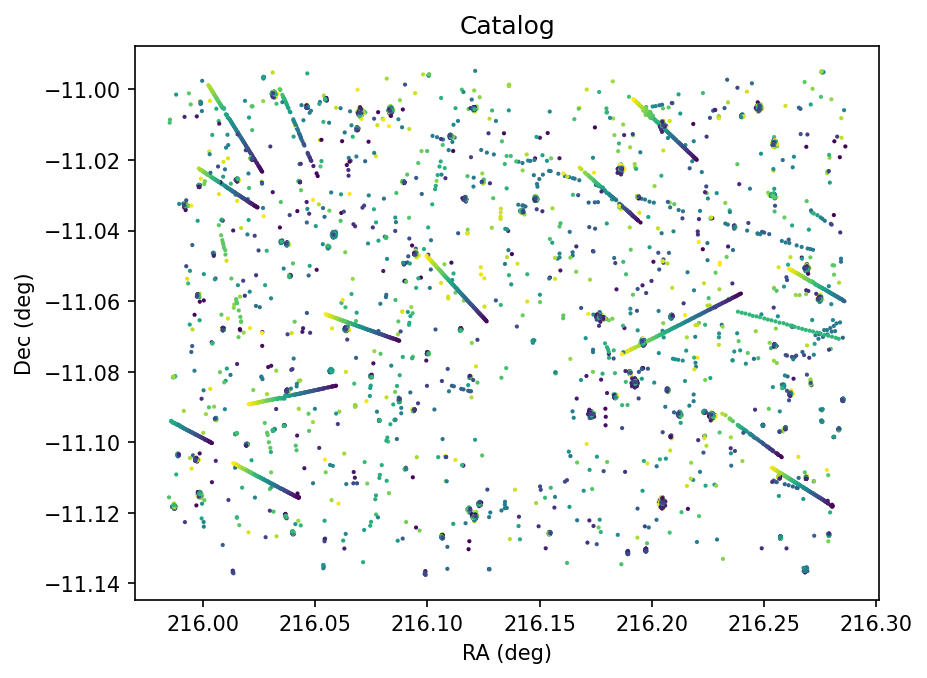

In [1]:
import astropy.table
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

catalog = astropy.table.Table.read("catalog.ecsv")
psfs = astropy.table.Table.read("psfs.ecsv")['psf']

sky_unit = u.deg
time_unit = u.day

X = np.array([catalog['ra'].to(sky_unit), catalog['dec'].to(sky_unit), catalog['time'].to(time_unit)]).T

fig = plt.figure(dpi=150, facecolor='white')
plt.scatter(X[:, 0], X[:, 1], c=X[:, 2], s=1)
plt.title("Catalog")
plt.xlabel(f"RA ({sky_unit})")
plt.ylabel(f"Dec ({sky_unit})")
plt.show()

We next run a `search` for these moving objects using the `find_objects` package. First, we define a set of directions we would like to search along using the `SearchDirections` class. We define the minimum of the times associated with the detection catalog as a reference epoch, along with ranges of the on-sky velocity and angles over which we wish to search. We choose the velocity range of `[0.1, 0.5] deg/day` to cover the expected on-sky velocity of Main Belt Asteroids. The angle range `[0, 359.99]` searches over all directions on the sky.

An important part of the `search` routine is to specify the $\Delta x$ or `dx` parameter, which sets the granularity in velocity with which the search is performed. Given a value `dx = 10 PSF-widths (arcsec)`, we visualize the set of velocities that will be searched, which is shaped like an annulus.

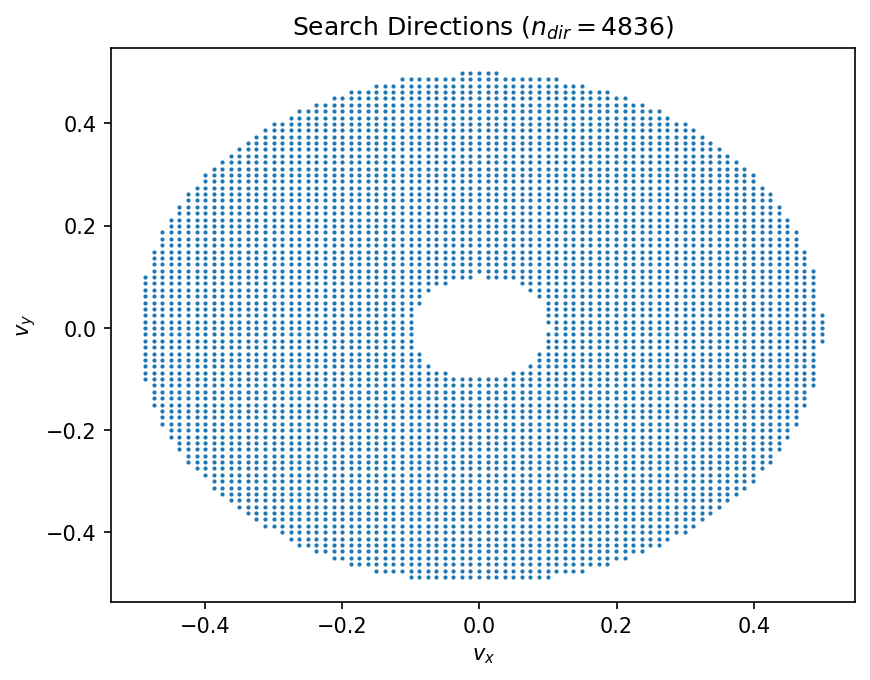

In [2]:
from find_asteroids.directions import SearchDirections

velocity_unit = sky_unit / time_unit
reference_epoch = X[:, 2].min() * time_unit

vmin, vmax = 0.1 * velocity_unit, 0.5 * velocity_unit
phimin, phimax = 0 * u.deg, 359.99 * u.deg

dt = (X[:, 2].max() - X[:, 2].min()) * time_unit
dx = (10 * np.median(psfs) * psfs.unit).to(u.arcsec)
directions = SearchDirections([vmin, vmax], [phimin, phimax], dx, dt)

fig = plt.figure(dpi=150, facecolor='white')
plt.scatter(directions.b[:, 0], directions.b[:,1 ], s=1)
plt.xlabel("$v_x$")
plt.ylabel("$v_y$")
plt.title(r"Search Directions ($n_{dir} = " + str(len(directions.b)) + r"$)")
plt.show()

We then call the `search` function of the `find_asteroids` package which performs the search. We just get the first result. Results will be ordered by their "significance", measured as the number of points that land in a bin of solid angle $\Delta x^2$ when the detection catlaog is projected to a reference epoch using one of the velocities specified above.

In [3]:
from find_asteroids.search import search

results, results_points = search(X, directions, dx, reference_epoch.value, num_results=1)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


cluster has value 104 at (1853, 153, 70)
8067 / 8171 points remain


The returned result provides the index of the search velocity which it corresponds to as well as the "significance" which we call the number of votes. Visualizing the points, we we captured a single moving object.

result:  [1853  153   70  104]
velocity:  [ 0.16172996 -0.46254359] deg / d
number of votes:  104


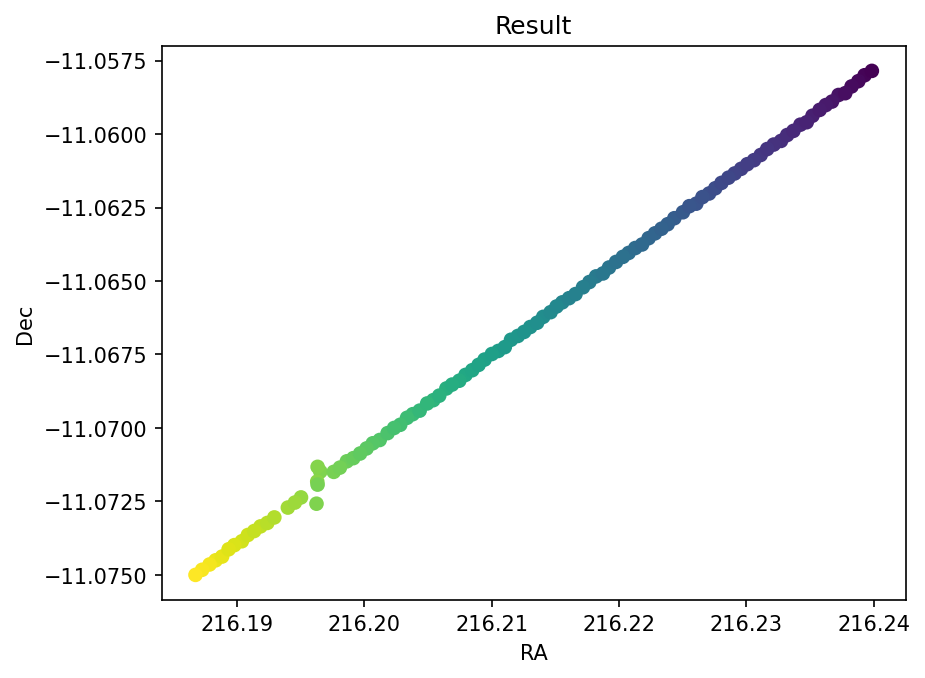

In [4]:
result = results[0]
points = results_points[0]

print("result: ", results[0])
velocity = directions.b[result[2]]
number_of_votes = result[3]
print("velocity: ", velocity)
print("number of votes: ", number_of_votes)

fig = plt.figure(dpi=150, facecolor='white')
plt.scatter(points[:, 0], points[:, 1], c=points[:, 2], label="Points")
plt.xlabel("RA")
plt.ylabel("Dec")
plt.title(f"Result")
plt.show()

A key component of the `find_asteroids` package is its ability to operate on low signal-to-noise (SNR) detection catalogs, or detection catalogs that contain noise and spurious results. This is enabled by the use of the `refine` and `gather` postprocessing utilities. The `refine` utility performs robust linear regression on the result points to improve the estimate of the object's trajectory. The `gather` utility then gathers points from the detection catalog that are within a specified distance of the refined trajectory.

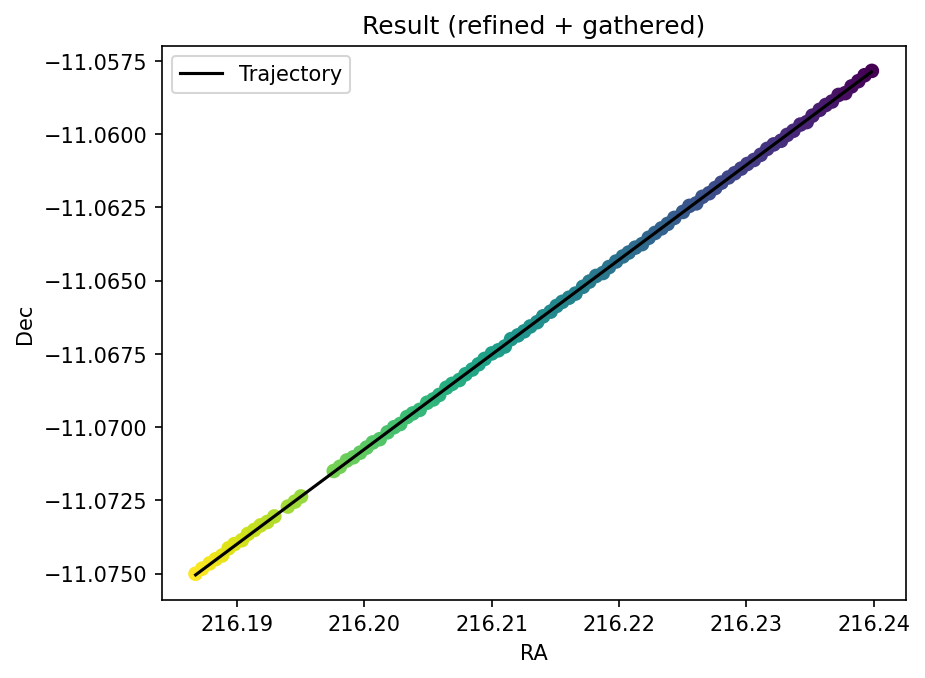

In [5]:
from find_asteroids.postprocess import refine, gather

# perform robust linear regression to trim outliers and improve the trajectory
refined = refine(points)
# collect points within 1 arcsec of the fit trajectory
gathered = gather(refined, X[:, 0], X[:, 1], X[:, 2], (1 * u.arcsec).to(sky_unit).value)
gathered_points = X[gathered]
_x = np.linspace(points[:, 2].min(), points[:, 2].max(), 100)[:, None]
_y = refined.predict(_x)

fig = plt.figure(dpi=150, facecolor='white')
plt.scatter(gathered_points[:, 0], gathered_points[:, 1], c=gathered_points[:, 2])
plt.plot(_y[:, 0], _y[:, 1], color='k', label="Trajectory")
plt.xlabel("RA")
plt.ylabel("Dec")
plt.title(f"Result (refined + gathered)")
plt.legend()
plt.show()


`find_asteroids` can also be used from the command line with an interface that is similar to what we specified in Python above. In the following, we find the top 20 results for candidate moving objects in this same detection catalog and using the same search parameters as before.

In [6]:
! find_asteroids --psfs psfs.ecsv --catalog catalog.ecsv --dx 10 --velocity 0.1 0.5 --angle 0 359.99 --results-dir ./results --threshold 20

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
cluster has value 104 at (1853, 153, 70)
8067 / 8171 points remain
cluster has value 104 at (2867, 144, 87)
7963 / 8171 points remain
cluster has value 104 at (3015, 102, 66)
7859 / 8171 points remain
cluster has value 103 at (2601, 85, 64)
7756 / 8171 points remain
cluster has value 103 at (2666, 65, 44)
7653 / 8171 points remain
cluster has value 97 at (2274, 72, 58)
7556 / 8171 points remain
cluster has value 95 at (2733, 171, 43)
7461 / 8171 points remain
cluster has value 92 at (3247, 57, 85)
7369 / 8171 points remain
cluster has value 88 at (2732, 56, 81)
7281 / 8171 points remain
cluster has value 72 at (2795, 179, 67)
7209 / 8171 points remain
cluster has value 67 at (2667, 47, 51)
7142 / 8171 points remain
cluster has value 65 at (2866, 133, 79)
7077 / 8171 points remain
cluster has value 48 at (2798, 161, 49)
7029 / 8171 points remain
cluster has value 47 at (3400, 68, 85)
6982 / 

The results are output into a directory called `results` from which we can extract the putative moving object detections. In the following, we plot the detection catalog and the 20 moving object candidates as blue lines. We can see that the moving objects have been recovered.

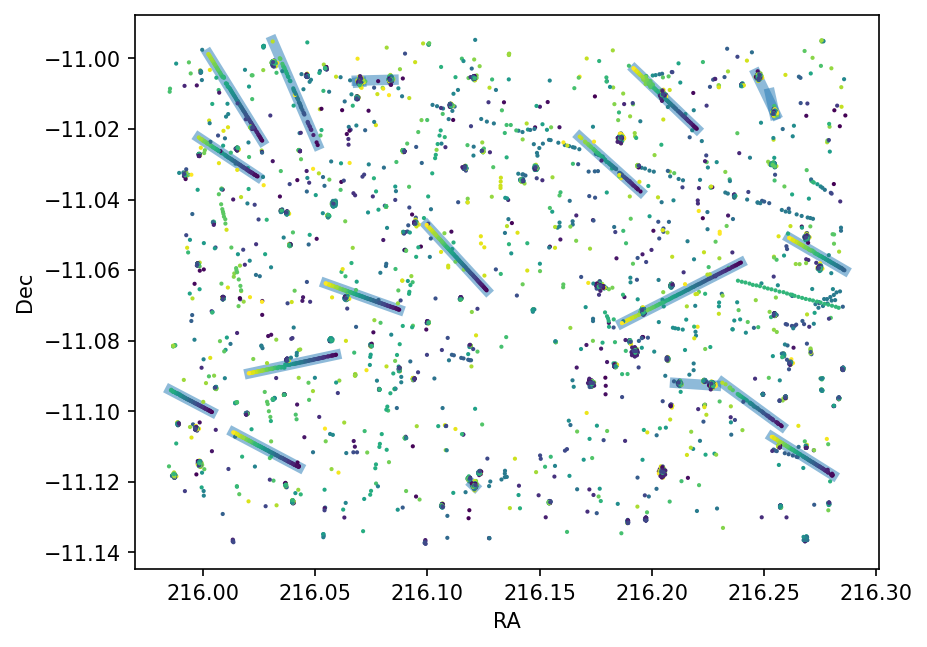

In [7]:
from pathlib import Path

fig = plt.figure(dpi=150, facecolor='white')
plt.scatter(catalog['ra'], catalog['dec'], c=catalog['time'], s=1, zorder=1)

result_paths = list(Path("results").glob("*"))
result_paths
for result_path in result_paths:
    tracklet = astropy.table.Table.read(result_path / "tracklet.ecsv")[0]

    _time = np.linspace(tracklet['tmin'], tracklet['tmax'], 100)[:, None]
    y_pred_ra = tracklet['vra'] * _time + tracklet['ra_0']
    y_pred_dec = tracklet['vdec'] * _time + tracklet['dec_0']
    
    plt.plot(y_pred_ra, y_pred_dec, lw=5, alpha=0.5, color='C0', zorder=0)

plt.xlabel("RA")
plt.ylabel("Dec")
plt.show()

A few of the candidate moving objects are spurious, which should be filtered out. While the `find_asteroids` package does not currently supply filtering methods, simple metrics, such as the number of detections can be used to separate real from fake moving object candidates.

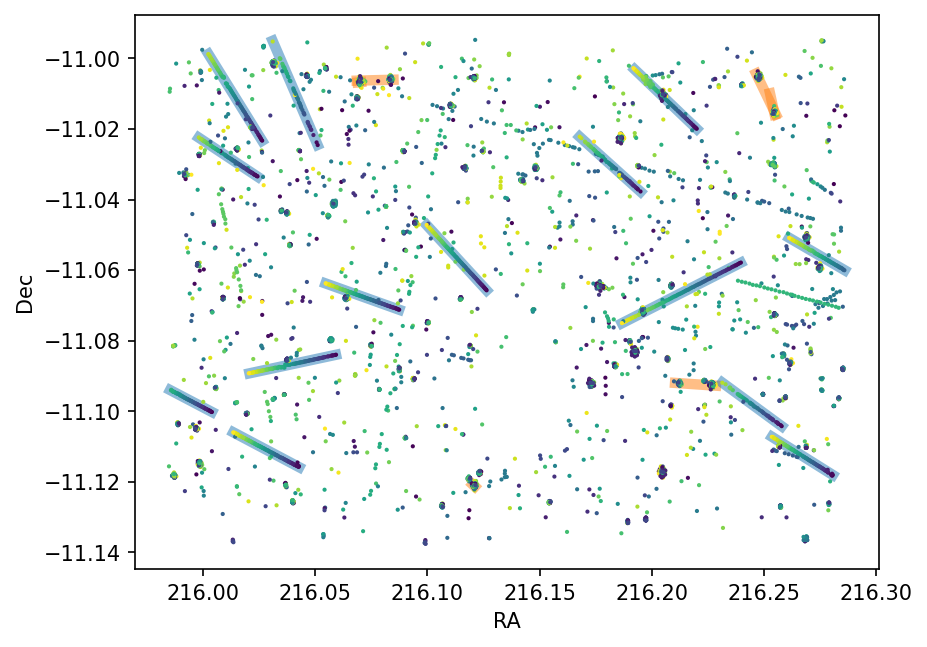

In [8]:
from pathlib import Path

fig = plt.figure(dpi=150, facecolor='white')
plt.scatter(catalog['ra'], catalog['dec'], c=catalog['time'], s=1, zorder=1)

result_paths = list(Path("results").glob("*"))
result_paths
for result_path in result_paths:
    result_num = result_path.name
    gathered = astropy.table.Table.read(result_path / "gathered.ecsv")
    n = len(gathered)
    if n < 30:
        color = 'C1'
    else:
        color = 'C0'

    tracklet = astropy.table.Table.read(result_path / "tracklet.ecsv")[0]

    _time = np.linspace(tracklet['tmin'], tracklet['tmax'], 100)[:, None]
    y_pred_ra = tracklet['vra'] * _time + tracklet['ra_0']
    y_pred_dec = tracklet['vdec'] * _time + tracklet['dec_0']
    
    plt.plot(y_pred_ra, y_pred_dec, lw=5, alpha=0.5, color=color, zorder=0)

plt.xlabel("RA")
plt.ylabel("Dec")
plt.show()